In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType


In [2]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("Combine CSV Files") \
    .getOrCreate()


file_paths = [
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00000-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00001-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00002-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00003-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00004-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00005-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00006-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00007-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00008-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv"
]


dataframes = [spark.read.csv(file, header=True, inferSchema=True) for file in file_paths]


df = dataframes[0]
for df in dataframes[1:]:
    df = df.union(df)


df.show()


24/12/10 15:44:55 WARN Utils: Your hostname, Elviss-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.57 instead (on interface en0)
24/12/10 15:44:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/10 15:44:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/10 15:44:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/10 15:44:59 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/12/10 15:46:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+-----+-----------------+----------+--------+-------------------+-------------------+---------+------------------+------------------+--------------------+--------------+-----------+------------+--------------+--------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+-----------+-----------+----+----+------------------+
|State|Month|Weather_Condition|    County|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|      Distance(mi)|                City|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Civil_Twilight|Day_of_Week|Day_of_Year|Year|Hour|  Traffic_Duration|
+-----+-----+-----------------+----------+--------+-------------------+-------

+--------+------+
|Severity| count|
+--------+------+
|       2|361104|
|       3|101296|
|       4| 81382|
+--------+------+



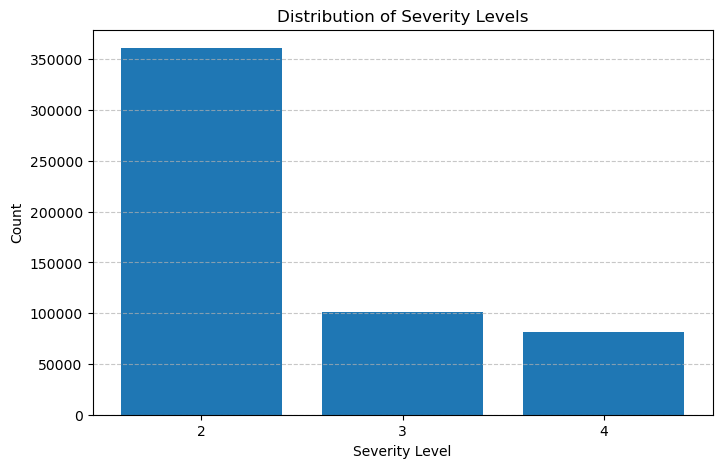

In [3]:
from pyspark.sql import functions as F

# Count the distribution of Severity
severity_distribution = df.groupBy("Severity").count().orderBy("Severity")

# Show the distribution
severity_distribution.show()

# Convert to Pandas for visualization
severity_pandas = severity_distribution.toPandas()

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(severity_pandas['Severity'], severity_pandas['count'], tick_label=severity_pandas['Severity'])
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [4]:
feature_columns = [
    'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
    'Traffic_Duration', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
    'Traffic_Signal', 'Civil_Twilight'
]


In [5]:
# Identify categorical features
categorical_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight'
]

# Identify numerical features (rest of the columns)
numerical_features = [
    'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
    'Traffic_Duration'
]


In [6]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


# Step 1: Assemble numerical features into a single vector
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
df = assembler.transform(df)

# Step 2: Normalize the features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Step 3: View the normalized features
df.select("scaled_features").show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.44952567376578884,1.1874784995404355,-0.258015177571466,-1.7619069225349875,-0.35399684835904305,-0.30303419433830137,0.20157803299798782,-0.33310526076141483,-0.051169878602791624,0.005762433493609487]|
|[0.4380145048239234,1.1828932839011006,-0.40725940825460605,-1.4890666790636622,0.08037507711605565,-0.33199465443980564,0.20157803299798782,0.31989691523872654,-0.051

In [7]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType

# Ensure all BooleanType columns are cast to StringType
for col in categorical_features:
    if dict(df.dtypes)[col] == "boolean":
        df = df.withColumn(col, F.col(col).cast(StringType()))

# Step 1: StringIndexer for each categorical feature
# Temporarily write to new columns
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_temp") 
    for col in categorical_features
]

# Step 2: Create a pipeline for StringIndexing
pipeline = Pipeline(stages=indexers)
df_temp = pipeline.fit(df).transform(df)

# Step 3: Overwrite original columns with the indexed ones
for col in categorical_features:
    df_temp = df_temp.drop(col).withColumnRenamed(f"{col}_temp", col)

# Step 4: Combine numerical and encoded categorical features into 'final_features'
assembler = VectorAssembler(
    inputCols=numerical_features + categorical_features, 
    outputCol="final_features"
)

df_prepared = assembler.transform(df_temp)

# Step 5: View the resulting DataFrame
df_prepared.select("final_features", "Severity").show(5, truncate=False)


+------------------------------------------------------------------------------------------------+--------+
|final_features                                                                                  |Severity|
+------------------------------------------------------------------------------------------------+--------+
|(23,[0,1,2,3,4,5,6,7,9],[40.06695,-75.66226999999998,0.253,32.0,55.0,29.4,10.0,7.0,360.0])      |2       |
|(23,[0,1,3,4,5,6,7,9,21],[40.00663,-75.7461,37.0,65.0,29.37,10.0,10.0,30.0,1.0])                |2       |
|(23,[0,1,3,4,5,6,7,9,21],[40.00663,-75.7461,37.0,65.0,29.37,10.0,10.0,30.0,1.0])                |2       |
|(23,[0,1,2,3,4,5,6,7,9],[40.15868,-77.69886,4.579,25.0,39.0,30.51,10.0,9.2,360.0])              |2       |
|(23,[0,1,2,3,4,5,6,7,9],[40.11231,-75.27999,0.398,32.0,55.0,30.13,10.0,9.220321336978788,360.0])|2       |
+------------------------------------------------------------------------------------------------+--------+
only showing top 5 rows



In [8]:
df_prepared.printSchema()

root
 |-- State: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- County: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- City: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Turning_Loop: boolean (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Day_of_Year: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Traffic_D

### Decision Tree Random Search

In [11]:
# Split the data into training and testing sets
train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)


In [12]:
import random

# Define the hyperparameter space
param_grid = {
    "maxDepth": [3, 5, 7, 10, 15],
    "maxBins": [10, 20, 40, 50],
    "minInstancesPerNode": [1, 5, 10],
    "impurity": ["gini", "entropy"]
}

# Generate random combinations of hyperparameters
def generate_random_params(param_grid, num_combinations=10):
    random_params = []
    for _ in range(num_combinations):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        random_params.append(params)
    return random_params

random_params_list = generate_random_params(param_grid, num_combinations=10)


In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")

best_model = None
best_accuracy = 0
best_params = None

# Train models for each parameter combination
for params in random_params_list:
    # Initialize Decision Tree with current parameters
    dt = DecisionTreeClassifier(
        featuresCol="final_features", 
        labelCol="Severity", 
        maxDepth=params["maxDepth"], 
        maxBins=params["maxBins"], 
        minInstancesPerNode=params["minInstancesPerNode"], 
        impurity=params["impurity"]
    )
    
    # Train the model
    model = dt.fit(train_data)
    
    # Evaluate the model
    predictions = model.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    
    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

# Print the best parameters and accuracy
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")


Best Parameters: {'maxDepth': 10, 'maxBins': 50, 'minInstancesPerNode': 5, 'impurity': 'entropy'}
Best Accuracy: 0.7016886361678297


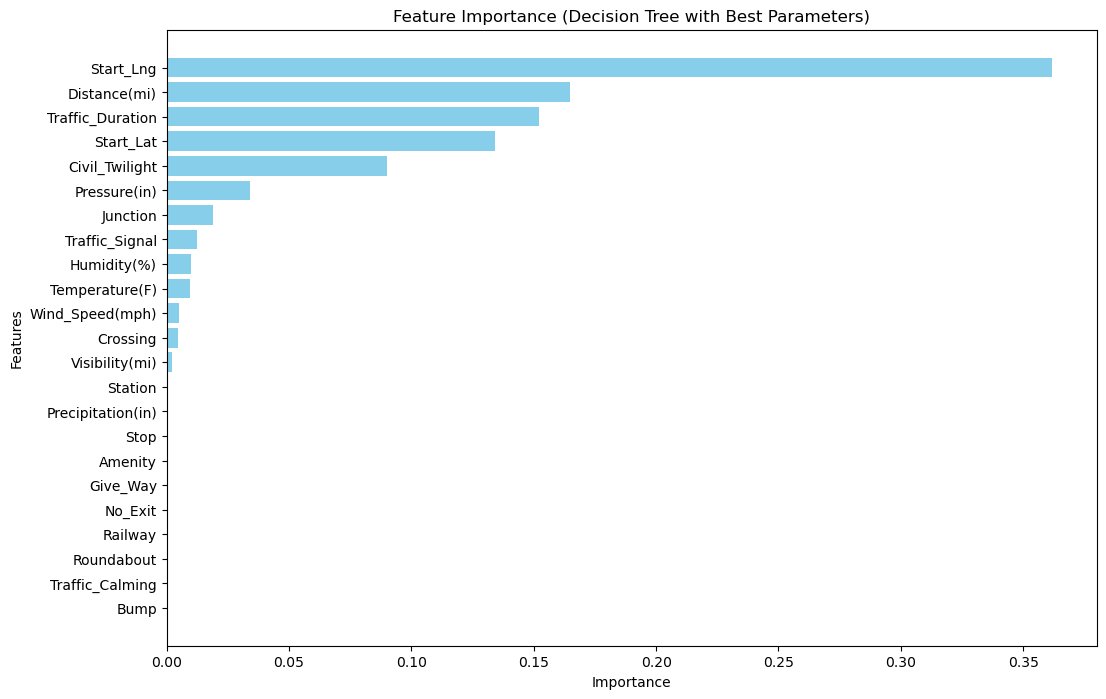

In [15]:
import pandas as pd

# Extract feature importances from the best model
feature_importance = best_model.featureImportances.toArray()

# Map feature names to their importances
feature_columns = numerical_features + categorical_features
feature_importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.title("Feature Importance (Decision Tree with Best Parameters)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


In [16]:
# Use the best model to make predictions on the test set
predictions = best_model.transform(test_data)


In [17]:
# Generate the Confusion Matrix
confusion_matrix = (
    predictions.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

# Display Confusion Matrix
confusion_matrix.show()


+--------+----------+------+
|Severity|prediction| count|
+--------+----------+------+
|       2|       2.0|101643|
|       2|       3.0|  2717|
|       2|       4.0|  3229|
|       3|       2.0| 23074|
|       3|       3.0|  5532|
|       3|       4.0|  1806|
|       4|       2.0| 16550|
|       4|       3.0|  1099|
|       4|       4.0|  6848|
+--------+----------+------+



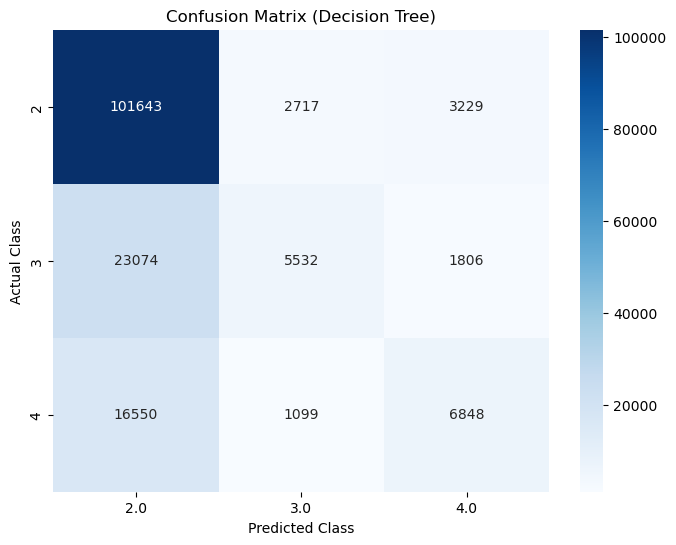

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Confusion Matrix to Pandas DataFrame
confusion_matrix_df = confusion_matrix.toPandas()

# Pivot the data to create a matrix-like structure
pivot_cm = confusion_matrix_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)

# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_cm, annot=True, fmt="g", cmap="Blues")

# Add titles and labels
plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


In [19]:
##Roc curve

In [20]:
# Show the predicted probabilities
predictions.select("Severity", "probability", "prediction").show(5, truncate=False)


+--------+--------------------------------------------------------------------+----------+
|Severity|probability                                                         |prediction|
+--------+--------------------------------------------------------------------+----------+
|2       |[0.0,0.0,0.7162343900096062,0.233045148895293,0.050720461095100866] |2.0       |
|2       |[0.0,0.0,0.5841247943969863,0.35013530004775295,0.06573990555526078]|2.0       |
|2       |[0.0,0.0,0.5841247943969863,0.35013530004775295,0.06573990555526078]|2.0       |
|2       |[0.0,0.0,0.5841247943969863,0.35013530004775295,0.06573990555526078]|2.0       |
|2       |[0.0,0.0,0.4977578475336323,0.289237668161435,0.21300448430493274]  |2.0       |
+--------+--------------------------------------------------------------------+----------+
only showing top 5 rows



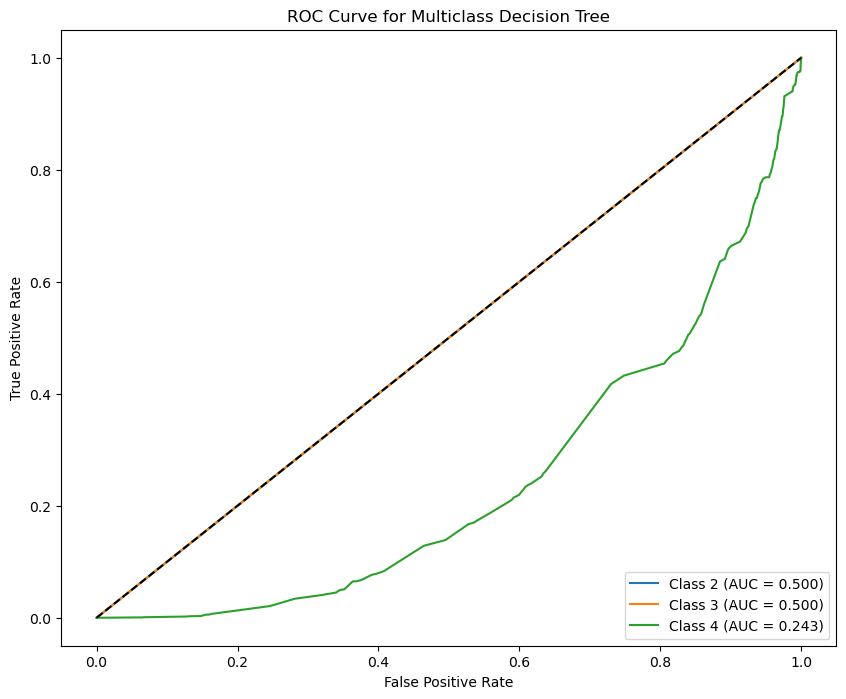

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Initialize plot
plt.figure(figsize=(10, 8))

# Unique classes in Severity
classes = [2, 3, 4]

# Loop through each class
for cls in classes:
    # Create binary labels for the current class
    predictions = predictions.withColumn(
        "binary_label", F.when(F.col("Severity") == cls, 1).otherwise(0)
    )
    
    # Extract probabilities for the current class
    prob_col = predictions.select("probability").rdd.map(lambda row: row[0][cls - 2]).collect()
    labels = predictions.select("binary_label").rdd.map(lambda row: row).collect()
    
    # Compute FPR and TPR using sklearn
    fpr, tpr, _ = roc_curve(labels, prob_col)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.3f})")

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], "k--")

# Add plot labels and legend
plt.title("ROC Curve for Multiclass Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [26]:
# Step 1: Export the predictions to Pandas
# Extract only the actual and predicted classes
predictions_pandas = predictions.select("Severity", "prediction").toPandas()

# Step 2: Use classification_report from scikit-learn
from sklearn.metrics import classification_report

# Actual classes (y_true) and predicted classes (y_pred)
y_true = predictions_pandas["Severity"]
y_pred = predictions_pandas["prediction"]

# Generate the classification report
# The target names map to Severity levels (e.g., 2 -> Class 2, etc.)
report = classification_report(y_true, y_pred, target_names=["Class 2", "Class 3", "Class 4"])
print(report)


              precision    recall  f1-score   support

     Class 2       0.72      0.94      0.82    107589
     Class 3       0.59      0.18      0.28     30412
     Class 4       0.58      0.28      0.38     24497

    accuracy                           0.70    162498
   macro avg       0.63      0.47      0.49    162498
weighted avg       0.67      0.70      0.65    162498



In [27]:
# Imbalancing


In [28]:
# Oversampling

In [29]:
# Filter each class
majority_class = df_prepared.filter(F.col("Severity") == 2)
minority_class_3 = df_prepared.filter(F.col("Severity") == 3)
minority_class_4 = df_prepared.filter(F.col("Severity") == 4)

# Calculate oversampling fraction for each minority class
oversample_fraction_3 = majority_class.count() / minority_class_3.count()
oversample_fraction_4 = majority_class.count() / minority_class_4.count()

# Oversample minority classes
oversampled_class_3 = minority_class_3.sample(withReplacement=True, fraction=oversample_fraction_3, seed=42)
oversampled_class_4 = minority_class_4.sample(withReplacement=True, fraction=oversample_fraction_4, seed=42)

# Combine majority class and oversampled minority classes
df_oversampled = majority_class.union(oversampled_class_3).union(oversampled_class_4)

# Verify new class distribution
df_oversampled.groupBy("Severity").count().show()


+--------+------+
|Severity| count|
+--------+------+
|       2|361104|
|       3|360845|
|       4|361115|
+--------+------+



In [31]:
# Split the oversampled data into training and test sets with `_over` suffix
train_data_over, test_data_over = df_oversampled.randomSplit([0.7, 0.3], seed=42)

# Initialize evaluator for the oversampled dataset
evaluator_over = MulticlassClassificationEvaluator(
    labelCol="Severity", predictionCol="prediction", metricName="accuracy"
)

# Perform random search with `_over` suffix for variables
def random_search_decision_tree_over(train_data, test_data, param_grid, num_trials=10):
    best_model_over = None
    best_accuracy_over = 0
    best_params_over = None

    for _ in range(num_trials):
        # Randomly sample hyperparameters
        params = {k: random.choice(v) for k, v in param_grid.items()}
        
        # Initialize Decision Tree with sampled parameters
        dt = DecisionTreeClassifier(
            labelCol="Severity",
            featuresCol="features",
            maxDepth=params["maxDepth"],
            maxBins=params["maxBins"],
            minInstancesPerNode=params["minInstancesPerNode"],
            impurity=params["impurity"]
        )
        
        # Train the model
        model_over = dt.fit(train_data)
        
        # Evaluate the model
        predictions_over = model_over.transform(test_data)
        accuracy_over = evaluator_over.evaluate(predictions_over)
        
        # Update best model if current one is better
        if accuracy_over > best_accuracy_over:
            best_model_over = model_over
            best_accuracy_over = accuracy_over
            best_params_over = params

    return best_model_over, best_params_over, best_accuracy_over

# Perform random search on the oversampled dataset
best_model_over, best_params_over, best_accuracy_over = random_search_decision_tree_over(
    train_data_over, test_data_over, param_grid, num_trials=10
)

# Output the results for the oversampled dataset
best_params_over, best_accuracy_over


({'maxDepth': 10, 'maxBins': 10, 'minInstancesPerNode': 1, 'impurity': 'gini'},
 0.5675560147855663)

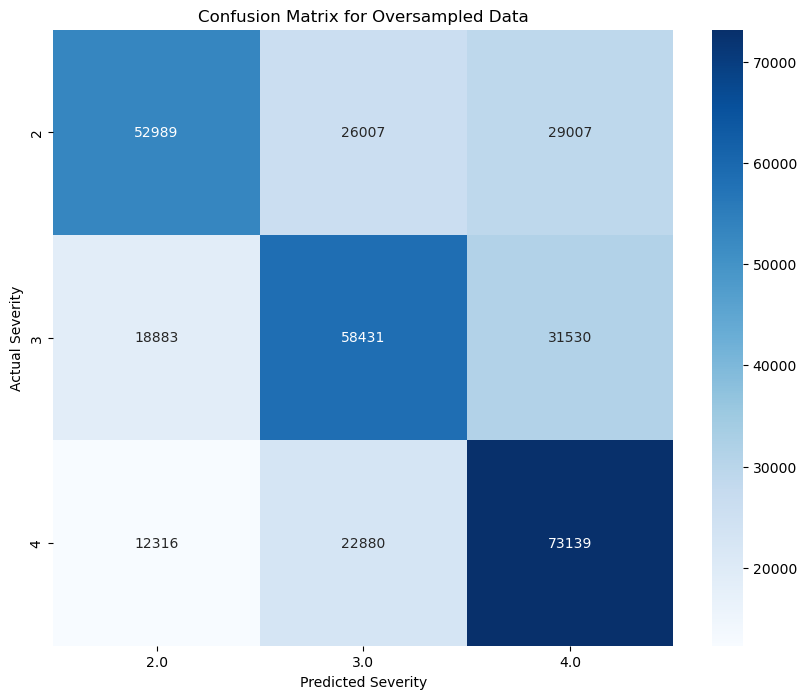

In [32]:
# Generate predictions using the best model on the oversampled test data
predictions_over = best_model_over.transform(test_data_over)

# Build the confusion matrix
confusion_matrix_over = (
    predictions_over.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

# Convert to Pandas for easier visualization
confusion_matrix_over_pd = confusion_matrix_over.toPandas()

# Pivot the data to create a matrix-like structure
confusion_matrix_pivot = confusion_matrix_over_pd.pivot(
    index="Severity", columns="prediction", values="count"
).fillna(0)

# Visualize the confusion matrix using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix for Oversampled Data")
plt.xlabel("Predicted Severity")
plt.ylabel("Actual Severity")
plt.show()


In [41]:
from pyspark.sql.functions import col
from sklearn.metrics import classification_report

# Step 1: Generate predictions
predictions_over = best_model_over.transform(test_data_over)

# Step 2: Convert predictions to Pandas DataFrame
predictions_pd_over = predictions_over.select(
    col("Severity").alias("Actual"),
    col("prediction").alias("Predicted")
).toPandas()

# Step 3: Generate classification report
report_over = classification_report(
    predictions_pd_over["Actual"],
    predictions_pd_over["Predicted"],
    target_names=[f"Severity {i}" for i in sorted(predictions_pd_over["Actual"].unique())]
)

# Print the classification report
print("Classification Report (Oversampled Data):")
print(report_over)


Classification Report (Oversampled Data):
              precision    recall  f1-score   support

  Severity 2       0.63      0.49      0.55    108003
  Severity 3       0.54      0.54      0.54    108844
  Severity 4       0.55      0.68      0.60    108335

    accuracy                           0.57    325182
   macro avg       0.57      0.57      0.57    325182
weighted avg       0.57      0.57      0.57    325182



In [42]:
## Undersampling

In [43]:
# Step 1: Separate the classes
majority_class = df_prepared.filter(F.col("Severity") == 2)
minority_class_3 = df_prepared.filter(F.col("Severity") == 3)
minority_class_4 = df_prepared.filter(F.col("Severity") == 4)

# Step 2: Determine the smallest class size
minority_size = min(minority_class_3.count(), minority_class_4.count())

# Step 3: Downsample the majority class
undersampled_majority = majority_class.sample(withReplacement=False, fraction=minority_size / majority_class.count(), seed=42)

# Step 4: Combine the downsampled majority class with the minority classes
df_undersampled = undersampled_majority.union(minority_class_3).union(minority_class_4)

# Step 5: Verify the class distribution
df_undersampled.groupBy("Severity").count().show()


+--------+------+
|Severity| count|
+--------+------+
|       2| 81641|
|       3|101296|
|       4| 81382|
+--------+------+



In [44]:
# Split the undersampled data into training and test sets
train_data_under, test_data_under = df_undersampled.randomSplit([0.7, 0.3], seed=42)

# Define the evaluator for the undersampled dataset
evaluator_under = MulticlassClassificationEvaluator(
    labelCol="Severity", predictionCol="prediction", metricName="accuracy"
)

# Perform random search for hyperparameter tuning on the undersampled dataset
def random_search_decision_tree_under(train_data, test_data, param_grid, num_trials=10):
    best_model_under = None
    best_accuracy_under = 0
    best_params_under = None

    for _ in range(num_trials):
        # Randomly sample hyperparameters
        params = {k: random.choice(v) for k, v in param_grid.items()}
        
        # Initialize Decision Tree with sampled parameters
        dt = DecisionTreeClassifier(
            labelCol="Severity",
            featuresCol="features",
            maxDepth=params["maxDepth"],
            maxBins=params["maxBins"],
            minInstancesPerNode=params["minInstancesPerNode"],
            impurity=params["impurity"]
        )
        
        # Train the model
        model_under = dt.fit(train_data)
        
        # Evaluate the model
        predictions_under = model_under.transform(test_data)
        accuracy_under = evaluator_under.evaluate(predictions_under)
        
        # Update best model if current one is better
        if accuracy_under > best_accuracy_under:
            best_model_under = model_under
            best_accuracy_under = accuracy_under
            best_params_under = params

    return best_model_under, best_params_under, best_accuracy_under

# Perform random search on the undersampled dataset
best_model_under, best_params_under, best_accuracy_under = random_search_decision_tree_under(
    train_data_under, test_data_under, param_grid, num_trials=10
)

# Output the best hyperparameters and accuracy
best_params_under, best_accuracy_under


24/12/10 17:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1076.8 KiB
24/12/10 17:12:11 WARN DAGScheduler: Broadcasting large task binary with size 1287.4 KiB
24/12/10 17:12:15 WARN DAGScheduler: Broadcasting large task binary with size 1560.9 KiB
24/12/10 17:12:19 WARN DAGScheduler: Broadcasting large task binary with size 1893.2 KiB
24/12/10 17:12:27 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB
24/12/10 17:13:38 WARN DAGScheduler: Broadcasting large task binary with size 1094.8 KiB
24/12/10 17:13:40 WARN DAGScheduler: Broadcasting large task binary with size 1319.2 KiB
24/12/10 17:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1606.1 KiB
24/12/10 17:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1957.7 KiB
24/12/10 17:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1305.0 KiB
24/12/10 17:15:01 WARN DAGScheduler: Broadcasting large task binary with size 1123.6 KiB
24/12/10 17:15:01 WAR

({'maxDepth': 15,
  'maxBins': 40,
  'minInstancesPerNode': 1,
  'impurity': 'entropy'},
 0.632222754672249)

24/12/10 17:18:54 WARN DAGScheduler: Broadcasting large task binary with size 1936.6 KiB
24/12/10 17:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1635.0 KiB
24/12/10 17:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1635.2 KiB
24/12/10 17:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1633.4 KiB


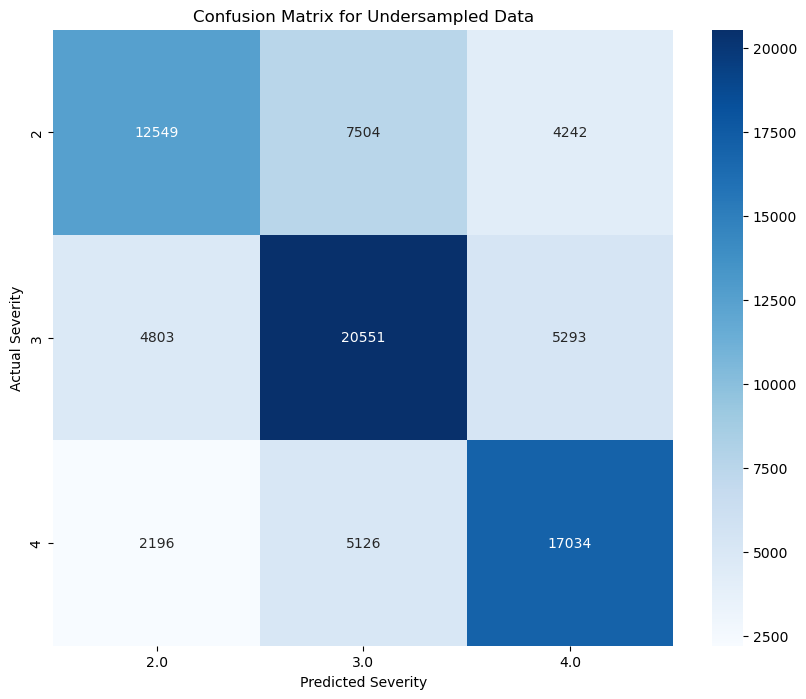

In [45]:
# Generate predictions using the best model on the undersampled test data
predictions_under = best_model_under.transform(test_data_under)

# Build the confusion matrix for the undersampled dataset
confusion_matrix_under = (
    predictions_under.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

# Convert to Pandas for easier visualization
confusion_matrix_under_pd = confusion_matrix_under.toPandas()

# Pivot the data to create a matrix-like structure
confusion_matrix_pivot_under = confusion_matrix_under_pd.pivot(
    index="Severity", columns="prediction", values="count"
).fillna(0)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_pivot_under, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix for Undersampled Data")
plt.xlabel("Predicted Severity")
plt.ylabel("Actual Severity")
plt.show()


In [48]:
from sklearn.metrics import classification_report

# Step 1: Convert predictions for the oversampled dataset to Pandas
predictions_over_pd = predictions_over.select(
    col("Severity").alias("Actual"),
    col("prediction").alias("Predicted")
).toPandas()

# Step 2: Generate classification report for oversampled dataset
classification_report_over = classification_report(
    predictions_over_pd["Actual"],
    predictions_over_pd["Predicted"],
    target_names=[f"Severity {i}" for i in sorted(predictions_over_pd["Actual"].unique())]
)

# Display the classification report
print("Classification Report for Oversampled Data:")
print(classification_report_over)


Classification Report for Oversampled Data:
              precision    recall  f1-score   support

  Severity 2       0.63      0.49      0.55    108003
  Severity 3       0.54      0.54      0.54    108844
  Severity 4       0.55      0.68      0.60    108335

    accuracy                           0.57    325182
   macro avg       0.57      0.57      0.57    325182
weighted avg       0.57      0.57      0.57    325182

